# Testing the action potential of cell models by using standard parameters


In [1]:
# fileName

fileName = 'eg_testing-cell-models'

# run only with spinnaker


In [2]:
try:
    import pyNN.spiNNaker as sim
    # run only with spinnaker
except ModuleNotFoundError:
    import pyNN.brian2 as sim
    
from pyNN import space 
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pickle
import time
import datetime
import json
import warnings
warnings.filterwarnings('ignore')
import python_utils as pu

savePath = f'../outputs/' # remember to create the folder if not already present (mkdir ./notebooks/outputs)
dt_string = datetime.datetime.today().isoformat() # ISO8601 ! :-)
tag = dt_string 
saveName = f'{savePath}{fileName}-{tag}'
print(saveName)
PARS={}


../outputs/eg_testing-cell-models-2025-06-04T20:12:32.362779


In [3]:
# simulation settings

sim.setup(
        timestep=1, # [ms]
        min_delay=1, # [ms]
        max_delay=100) # [ms]

simtime = 250 # [ms+]



2025-06-04 20:12:32 INFO: Read cfg files: /home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spinn_front_end_common/interface/spinnaker.cfg, /home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spynnaker/pyNN/spynnaker.cfg, /home/bbpnrsoa/.spynnaker.cfg
2025-06-04 20:12:32 INFO: Will search these locations for binaries: /home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spinn_front_end_common/common_model_binaries : /home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spynnaker/pyNN/model_binaries
2025-06-04 20:12:32 WARNING: /home/bbpnrsoa/CNT-2025/notebooks/intro/reports has 14 old reports that have not been closed
2025-06-04 20:12:32 INFO: Setting time scale factor to 10.
2025-06-04 20:12:32 INFO: Setting machine time step to 1000 micro-seconds.


['/home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spinn_front_end_common/interface/spinnaker.cfg', '/home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spynnaker/pyNN/spynnaker.cfg', '/home/bbpnrsoa/.spynnaker.cfg']


## make the network

In [4]:
# define make_pop

pops = {}

def make_pop(cell_model):
    pops = sim.Population(
                            1, # one cell in each cell model
                            cell_model,
                            cellparams=None, # std pars used
                            structure = space.Line(dx=1.0, x0=0.0, y=0.0, z=0.0),
                            initial_values=None,
                            label=str(cell_model),
                            constraints=None,
                            additional_parameters=None,
                            )
    pops.record('v')
    
    return pops




In [5]:
# compute pops

for idx, value in enumerate([
                            sim.IF_cond_exp, 
                            sim.IF_curr_alpha,
                            sim.IF_curr_exp,
                            sim.Izhikevich,
                            sim.extra_models.IF_curr_dual_exp,
                            sim.extra_models.IFCondExpStoc,
                            sim.extra_models.IFCurDelta,
                            sim.extra_models.IFCurrExpCa2Adaptive,
                            sim.extra_models.Izhikevich_cond]):

    pops['model_' + str(idx)] = make_pop(value) 

In [6]:
# check pops

pops.keys()

dict_keys(['model_0', 'model_1', 'model_2', 'model_3', 'model_4', 'model_5', 'model_6', 'model_7', 'model_8'])

## make the thalamic input stimulus

In [7]:
# a sequence of ten spikes with regularly spaced spike times

pops['thalamus'] = sim.Population(
                            1, # one thalamic cell for each cell model
                            sim.SpikeSourceArray(np.arange(50,60)), # ten sequential spike times
                            structure = space.Line(dx=1.0, x0=0.0, y=0.0, z=0.0),
                            )    

pops.keys()

dict_keys(['model_0', 'model_1', 'model_2', 'model_3', 'model_4', 'model_5', 'model_6', 'model_7', 'model_8', 'thalamus'])

## make the projections

In [8]:
projs = {}

for i in range(9):
    projs['thalamus', 'model_' + str(i)] = sim.Projection(
                                    pops['thalamus'],
                                    pops['model_' + str(i)],
                                    sim.OneToOneConnector(),
                                    synapse_type=sim.StaticSynapse(weight=0.1, delay=1.0),
                                    receptor_type = 'excitatory',
                                    space = space.Space(axes = 'x'),
                                    label=None,
                                )

projs.keys()

dict_keys([('thalamus', 'model_0'), ('thalamus', 'model_1'), ('thalamus', 'model_2'), ('thalamus', 'model_3'), ('thalamus', 'model_4'), ('thalamus', 'model_5'), ('thalamus', 'model_6'), ('thalamus', 'model_7'), ('thalamus', 'model_8')])

## run the simulation

In [9]:
# simulation run

tic = time.time()
sim.run(simtime)
toc = time.time() - tic

2025-06-04 20:12:32 INFO: Starting execution process
2025-06-04 20:12:32 INFO: Simulating for 250 1.0ms timesteps using a hardware timestep of 10000us
Adding Splitter selectors where appropriate
|0%                          50%                         100%|
2025-06-04 20:12:32 INFO: Time 0:00:00.024024 taken by SpynnakerSplitterSelector
Adding delay extensions as required
|0%                          50%                         100%|
2025-06-04 20:12:32 INFO: Time 0:00:00.006799 taken by DelaySupportAdder
2025-06-04 20:12:36 INFO: Time 0:00:03.530644 taken by SpallocMaxMachineGenerator
Preallocating resources for Extra Monitor support vertices
|0%                          50%                         100%|
2025-06-04 20:12:49 INFO: Time 0:00:13.228822 taken by PreAllocateResourcesForExtraMonitorSupport
Partitioning graph vertices
|0%                          50%                         100%|
Partitioning graph edges
|0%                          50%                         100%|
2025-06-

## save results

In [10]:
# save the results

outputs = {}

for i in range(9):
    outputs['model_' + str(i)] = pops['model_' + str(i)].get_data()
    for recording in ['v', 'gsyn_inh', 'gsyn_exc', 'spikes']:
        pops['model_' + str(i)].write_data(f'{saveName}-{recording}.pkl')


Getting v for <class 'spynnaker.pyNN.models.neuron.builds.if_cond_exp_base.IFCondExpBase'>
|0%                          50%                         100%|
Getting v for <class 'spynnaker.pyNN.models.neuron.builds.if_cond_exp_base.IFCondExpBase'>
|0%                          50%                         100%|
Getting v for <class 'spynnaker.pyNN.models.neuron.builds.if_cond_exp_base.IFCondExpBase'>
|0%                          50%                         100%|
Getting v for <class 'spynnaker.pyNN.models.neuron.builds.if_cond_exp_base.IFCondExpBase'>
|0%                          50%                         100%|
Getting v for <class 'spynnaker.pyNN.models.neuron.builds.if_cond_exp_base.IFCondExpBase'>
|0%                          50%                         100%|
Getting v for <class 'spynnaker.pyNN.models.neuron.builds.if_curr_alpha.IFCurrAlpha'>
|0%                          50%                         100%|
Getting v for <class 'spynnaker.pyNN.models.neuron.builds.if_curr_alpha.IFCurrAlp

## recover results

In [11]:
# make the recover results function

def recover_results(outputs):
    results = {}
    for key in outputs.keys(): 
        
        # to get voltage and conductances
        for analogsignal in outputs[key].segments[0].analogsignals:
            print(analogsignal.name)
            results[key, analogsignal.name] = analogsignal

        # to get spikes
        results[key, 'spikes'] = outputs[key].segments[0].spiketrains
    return results


In [12]:
# recover results

results = recover_results(outputs)
results.keys()

v
v
v
v
v
v
v
v
v


dict_keys([('model_0', 'v'), ('model_0', 'spikes'), ('model_1', 'v'), ('model_1', 'spikes'), ('model_2', 'v'), ('model_2', 'spikes'), ('model_3', 'v'), ('model_3', 'spikes'), ('model_4', 'v'), ('model_4', 'spikes'), ('model_5', 'v'), ('model_5', 'spikes'), ('model_6', 'v'), ('model_6', 'spikes'), ('model_7', 'v'), ('model_7', 'spikes'), ('model_8', 'v'), ('model_8', 'spikes')])

## check the voltage signature

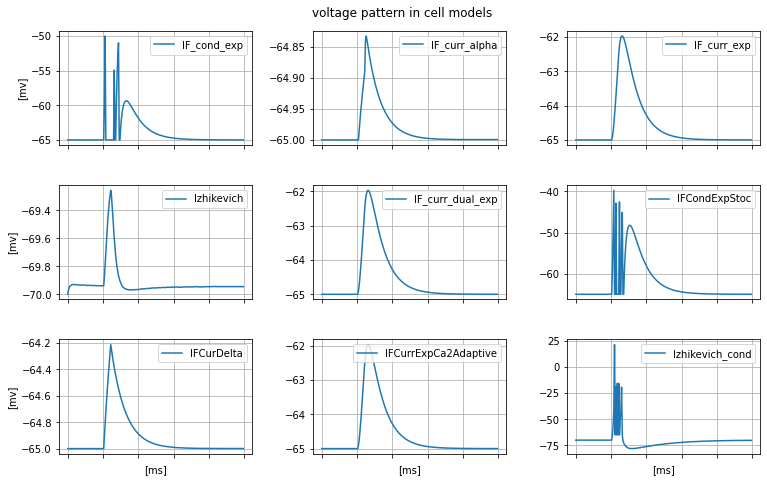

In [15]:
%matplotlib inline

fig, axes = plt.subplots(3, 3, sharex=True, sharey=False, figsize=(11,7))
fig.tight_layout(pad=3)
fig.suptitle('voltage pattern in cell models')
labels=['IF_cond_exp','IF_curr_alpha',
        'IF_curr_exp','Izhikevich', 
        'IF_curr_dual_exp', 'IFCondExpStoc',
        'IFCurDelta', 'IFCurrExpCa2Adaptive', 'Izhikevich_cond']

axes_list = axes.flatten()
idx = 0
for i in range(9):
    im = axes_list[i].plot(results['model_' + str(i), 'v'], label=labels[i])
    axes_list[i].set_xticklabels([])
    axes_list[i].grid(which='both')
    if i==0 or i==3 or i==6:
        axes_list[i].set_ylabel('[mv]')
    if i==6 or i==7 or i==8:
        axes_list[i].set_xlabel('[ms]')
    #axes_list[i].axhline(y=-55, label='action potential threshold', color='r', alpha=0.5) 
    axes_list[i].legend(loc='upper right')


fig.savefig(f'{saveName}.jpeg', dpi=70, bbox_inches='tight', facecolor='white')

In [14]:
# end simulation

sim.end()

## Question: are all of these stimulus-related voltage patterns action potentials?

Think about what's the condition to get a neural action potential and the meaning of "integrate" and "fire" terms

## Task 1: on the action potential of cell models

- Have a look of the plot, you should observe the different voltage signatures having similarities as well as differences. <br>
  Describe them or try making a classification by adopting criteria indicated in this bottom image<br>
  
  e.g., 
      - depolarization timing
      - shape of depolarization
      - action potential timing
      - shape of repolarization
      - presence/absence of refractory period
      - resting state timing
      
      
- This simulation has been done with standard parameters. <br>
  Choose a parameter shared from all the models and tune it. <br>
  Observe how the voltage trace of the action potential changes. <br>
  To explore the default paramters, use e.g., `sim.IF_cond_exp.default_parameters` <br>
  Change them by defining a new dictionary of pars for each model call e.g., pars[model_x]<br>
  

![](https://upload.wikimedia.org/wikipedia/commons/4/4a/Action_potential.svg)

## Task 2: on the network of different cell models

- The previous results are related to single behaviour of the given cell models.<br>
  Try to make a population of 25 cells for each model and record their voltage.<br>
  The input should be design as a sequence of ten input spikes separeted 150 ms for each model.<br>
  E.g., the first model receives input at 50-59ms, the second at 200-209ms, the third at 350-359ms etc.<br>
  Plot the results in a single plot showing the all traces that should appear sequentally displayed.<br>
  Set the simtime at 1500ms.